In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from IPython.core.display import display, HTML
import os
import tempfile

from auxiliary import grids_skf_lr, grids_skf_lsvc, grids_skf_rf, grids_skf_svc, \
    grids_skf_xgb, plot_cm, plot_elbow_kmeans, plot_nn_metrics, plot_pr_curve, \
    plot_roc, save_metrics

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
# Load of pre processed data
%run -i data_pre_proc.py

	2 columns, ['EmployeeCount', 'StandardHours'] were droped
	The ['Over18'] column was droped.
	Pattern " " cleared.
	Pattern "Travel_" cleared.
	Pattern "-" cleared.
	Pattern "&" cleared.
--------------------------------------------------------------------------
 Pre-processing concluded on  ../Data/HR_DS.csv with success.
 Dataframes produced: finaldf
 Other instances created: n_features
 ___________________________________________________________________________


# I. Introduction and Workflow
Our approach to the problem at hand is as follows in the next flowchart or pipeline. This was due, namely, to the fact that: 
1. The dataset is imbalanced;
2. There is no time dimension to the data available;
3. There is no great volume of data

First, the dataset will be split into 2 stratified sets of data so that the following is available:
* A train dataset (features and labels appart) (90%)
    * The models will be trained and validated on this subset;
    * For sake of reproducibility we will apply the same techniques in order to find the best performance model;
    * The best model(s) will be selected to train on this full data subset before being tested against the test dataset (as follows)
* A test dataset (features and labels appart) (10%)
    * This will be used to test the final models as an out-of-sample dataset.
    
After the selection of best model(s) there will be extracted feature importance by permutation and a cluster analysis/profiling.
The resulting insights will be used as an holistic advise on:
* Feature Improvement to avoid atritrion
* Attrition Prediction

In [3]:
display(HTML('../resources/modeling.html'))

# II. Models

## A. Settings and global instances

In [4]:
# test 10%; train 90%
train_df, test_df = train_test_split(finaldf, test_size=0.1, random_state=0, stratify=finaldf.Attrition_Yes)

# Initialization of min-max normalizing scaler
minmax = MinMaxScaler()

# Form np arrays of labels and features
train_labels = np.array(train_df.Attrition_Yes)
test_labels = np.array(test_df.Attrition_Yes)

# The train and test features will be normalized separatedly in order not to cross-contaminate data
train_features = train_df.drop('Attrition_Yes', axis=1)
test_features = minmax.fit_transform(test_df.drop('Attrition_Yes', axis=1))
train_features_norm = minmax.fit_transform(train_features)

# vectorize train features
train_features_v = np.array(train_features)

# initialization of the dataframe to store the metrics for each model evaluated on test split
m_summary = pd.DataFrame(columns=[
    'model','tp', 'fp', 'tn', 'fn', 
    'bal_acc', 'prec', 'recall', 'pr_auc', 'f1', 'mc_coef', 
    'batch_s', 'data', 'series'
])

# standart number of folds to be used by StratifiedKfold sampling
n_folds = 5

print('Training labels shape:', train_labels.shape)
print('Test labels shape:', test_labels.shape)
print('')
print('Training features shape:', train_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (1323,)
Test labels shape: (147,)

Training features shape: (1323, 41)
Test features shape: (147, 41)


In [5]:
# Instantiate the cross validator
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=0)

### A.1. Imbalanced Series (original weights)
A check on the imbalance of the datasets is needed as follows:

In [6]:
neg_df, pos_df = np.bincount(finaldf.Attrition_Yes)
total_df = neg_df + pos_df
neg_test, pos_test = np.bincount(test_labels)
total_test = neg_test + pos_test
neg_t, pos_t = np.bincount(train_labels)
total_t = neg_t + pos_t

print('Cases on full dataset:\n\tTotal: {}\n\tEmployees that Left the company: {} ({:.2f}% of total)\n'.format(
    total_df, pos_df, 100 * pos_df / total_df))
print('\tCases on test dataset:\n\t\tTotal: {}\n\t\tEmployees that Left the company: {} ({:.2f}% of total)\n'.format(
    total_test, pos_test, 100 * pos_test / total_test))
print('\tCases on training dataset:\n\t\tTotal: {}\n\t\tEmployees that Left the company: {} ({:.2f}% of total)\n'.format(
    total_t, pos_t, 100 * pos_t / total_t))

Cases on full dataset:
	Total: 1470
	Employees that Left the company: 237 (16.12% of total)

	Cases on test dataset:
		Total: 147
		Employees that Left the company: 24 (16.33% of total)

	Cases on training dataset:
		Total: 1323
		Employees that Left the company: 213 (16.10% of total)



A determination of the weights of the target label (train dataset) will be important further on the testing of the models

In [7]:
# Scaling by total/2(categories) helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg_t)*(total_t)/2
weight_for_1 = (1 / pos_t)*(total_t)/2

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0 (Stayers): {:.2f}'.format(weight_for_0))
print('Weight for class 1 (Leavers): {:.2f}'.format(weight_for_1))

Weight for class 0 (Stayers): 0.60
Weight for class 1 (Leavers): 3.11


### A.2. Oversampled Series (SMOTE)
In order to minimize impact of the imbalance on the original dataset, We'll be using SMOTE to generate artificial data based on the k nearest neighbours of the train data subset.

In [8]:
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


Creation of A new Dataframe from the Train_df but assigning extra weight to the label Attrition to better compute optimal clusters knowing that an Employee that exist the company is from a different cluster than the other, assuming that there are common features shared in this group. 

In [19]:
traindf_norm = pd.DataFrame(minmax.fit_transform(train_df), columns=train_df.columns)
traindf_norm.Attrition_Yes = traindf_norm.Attrition_Yes*2

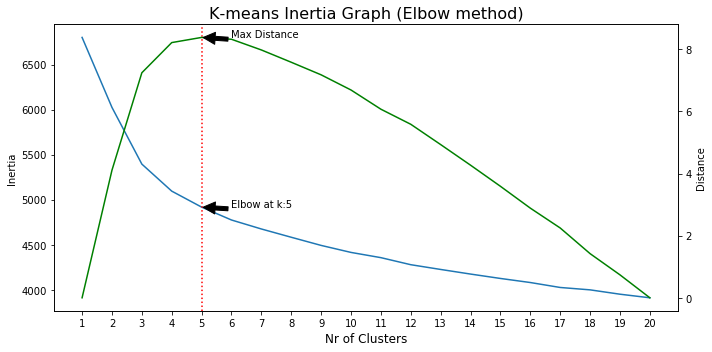

The best number of clusters is 5


In [21]:
n_kn = plot_elbow_kmeans(traindf_norm, 20)

In [22]:
smote = SMOTE(
    k_neighbors=n_kn,
    random_state=0,
    n_jobs=-1
)

In [24]:
# producing the data subset oversampled
X_SMOTE, y_SMOTE = smote.fit_sample(train_features, train_labels)

X_SMOTE_mm = minmax.fit_transform(X_SMOTE)

This data subset will have equal weights for both classes of the target labels. In this case the artificial data produced belong to class '1', the employees who have left the company (Attrition = Yes)

## 1. XGBoost

### 1.1. Imbalanced Series

#### 1.1.1. Optimization - GridSearch & Stratified K-Fold CV

In [28]:
# fit model on training data
parameters_XGB = {
    'objective':['binary:logistic'],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [i for i in range(3,7)],
    'subsample': [0.5, 1],
    'colsample_bytree': [0.5, 1],
    'n_estimators': [100, 1000, 2000],
    'seed': [123]}

model_XGB = grids_skf_xgb(
    train_features,
    train_labels, 
    parameters_XGB, 
    pos_t/neg_t, 
    n_folds
)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  2.9min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=2000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.1918918918918919,
              seed=123, silent=None, subsample=1, verbosity=0)


#### 1.1.2. Evaluation - Stratified K-Fold CV

In [29]:
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_features_norm[train_indices], train_features_norm[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # train model
    model_XGB.fit(xtrain, ytrain)
    
    m_summary = save_metrics(
        m_summary, 'model_XGB', ytrain, model_XGB.predict(xtrain), model_XGB.predict_proba(xtrain)[:, 1], 
        split_data='train', series='imbalanced')
    m_summary = save_metrics(
        m_summary, 'model_XGB', yval, model_XGB.predict(xval), model_XGB.predict_proba(xval)[:, 1], 
        split_data='val', series='imbalanced')
    m_summary = save_metrics(
        m_summary, 'model_XGB', test_labels, model_XGB.predict(test_features), model_XGB.predict_proba(test_features)[:, 1], 
        split_data='test', series='imbalanced')
print('...Done')

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
...Done


### 1.2. Oversampling Series

#### 1.2.1. Optimization - GridSearch & Stratified K-Fold CV

In [33]:
# fit model on training data
model_XGB_smote = grids_skf_xgb(
    X_SMOTE,
    y_SMOTE, 
    parameters_XGB,
    1,
    n_folds
)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  4.8min


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
              silent=None, subsample=0.5, verbosity=0)


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  5.6min finished


#### 1.2.2. Evaluation - Stratified K-Fold CV

In [39]:
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_v, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_features_v[train_indices], train_features_v[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # Oversampling training sets
    xtrain_SMOTE, ytrain_SMOTE = smote.fit_sample(xtrain, ytrain)
    xtrain_SMOTE = minmax.fit_transform(xtrain_SMOTE)
    
    # train model
    model_XGB_smote.fit(xtrain_SMOTE, ytrain_SMOTE)
    
    m_summary = save_metrics(
        m_summary, 'model_XGB', ytrain_SMOTE, model_XGB_smote.predict(xtrain_SMOTE), model_XGB_smote.predict_proba(xtrain_SMOTE)[:, 1], 
        split_data='train', series='SMOTE')
    m_summary = save_metrics(
        m_summary, 'model_XGB', yval, model_XGB_smote.predict(xval), model_XGB_smote.predict_proba(xval)[:, 1],
        split_data='val', series='SMOTE')
    m_summary = save_metrics(
        m_summary, 'model_XGB', test_labels, model_XGB_smote.predict(test_features), model_XGB_smote.predict_proba(test_features)[:, 1], 
        split_data='test', series='SMOTE')
print('...Done')

Training on fold 1/5...
Training on fold 2/5...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 3/5...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 4/5...
Training on fold 5/5...
...Done


## 2. Logistic Regression

### 2.1. Imbalanced Series

#### 2.1.1. Optimization - GridSearch & Stratified K-Fold CV

In [41]:
parameters_log = [{
    'solver' : ['sag'],
    'C' : [1, 10, 100],
    'max_iter': [10000],
    'penalty' : ('none', 'l2'),
    'warm_start' : (True, False),
    'fit_intercept' : [True, False]
},{
    'solver' : ['liblinear', 'saga'], 
    'C' : [1, 10, 100],
    'max_iter': [10000],
    'penalty' : ('l1', 'l2'),
    'warm_start' : (True, False),
    'fit_intercept' : [True, False]
}]

model_logistic = grids_skf_lr(
    train_features,
    train_labels, 
    parameters_log, 
    class_weights, 
    n_folds
)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 185 tasks      | elapsed:    8.2s


LogisticRegression(C=1,
                   class_weight={0: 0.595945945945946, 1: 3.1056338028169015},
                   dual=False, fit_intercept=False, intercept_scaling=1,
                   l1_ratio=None, max_iter=10000, multi_class='ovr', n_jobs=-1,
                   penalty='l2', random_state=0, solver='sag', tol=0.0001,
                   verbose=0, warm_start=True)


[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.0min finished


#### 2.1.2. Evaluation - Stratified K-Fold CV

In [43]:
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_features_norm[train_indices], train_features_norm[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # train model
    model_logistic.fit(xtrain, ytrain)
    
    m_summary = save_metrics(
        m_summary, 'model_logistic', ytrain, model_logistic.predict(xtrain), model_logistic.predict_proba(xtrain)[:, 1],
        split_data='train', series='imbalanced')
    m_summary = save_metrics(
        m_summary, 'model_logistic', yval, model_logistic.predict(xval), model_logistic.predict_proba(xval)[:, 1],
        split_data='val', series='imbalanced')
    m_summary = save_metrics(
        m_summary, 'model_logistic', test_labels, model_logistic.predict(test_features), model_logistic.predict_proba(test_features)[:, 1],
        split_data='test', series='imbalanced')
print('...Done')

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
...Done


### 2.2. Oversampling Series

#### 2.2.1. Optimization - GridSearch & Stratified K-Fold CV

In [45]:
model_logistic_smote = grids_skf_lr(
    X_SMOTE,
    y_SMOTE, 
    parameters_log,
    {0: 1, 1: 1},
    n_folds
)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   10.6s


LogisticRegression(C=1, class_weight={0: 1, 1: 1}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='ovr', n_jobs=-1, penalty='l1',
                   random_state=0, solver='saga', tol=0.0001, verbose=0,
                   warm_start=True)


[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   18.8s finished


#### 2.2.2. Evaluation - Stratified K-Fold CV

In [50]:
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_v, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_features_v[train_indices], train_features_v[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # Oversampling training sets
    xtrain_SMOTE, ytrain_SMOTE = smote.fit_sample(xtrain, ytrain)
    xtrain_SMOTE = minmax.fit_transform(xtrain_SMOTE)
    xval = minmax.fit_transform(xval)
    
    # train model
    model_logistic_smote.fit(xtrain_SMOTE, ytrain_SMOTE)
    
    m_summary = save_metrics(
        m_summary, 'model_logistic', ytrain_SMOTE, model_logistic.predict(xtrain_SMOTE), model_logistic.predict_proba(xtrain_SMOTE)[:, 1],
        split_data='train', series='SMOTE')
    m_summary = save_metrics(
        m_summary, 'model_logistic', yval, model_logistic.predict(xval), model_logistic.predict_proba(xval)[:, 1],
        split_data='val', series='SMOTE')
    m_summary = save_metrics(
        m_summary, 'model_logistic', test_labels, model_logistic.predict(test_features), model_logistic.predict_proba(test_features)[:, 1],
        split_data='test', series='SMOTE')
print('...Done')

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
...Done


## 3. LinearSVC

### 3.1. Imbalanced Series

#### 3.1.1. Optimization - GridSearch & Stratified K-Fold CV

In [52]:
parameters_lsvc = [{
    'C' : [i for i in range(1,10,2)],
    'penalty' : ['l1', 'l2'],
    'max_iter': [10000, 100000, 1000000]
}]

model_LinearSVC = grids_skf_lsvc(
    train_features, 
    train_labels, 
    parameters_lsvc, 
    class_weights, 
    n_folds
)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.6s


LinearSVC(C=1, class_weight={0: 0.595945945945946, 1: 3.1056338028169015},
          dual=False, fit_intercept=True, intercept_scaling=1,
          loss='squared_hinge', max_iter=10000, multi_class='ovr', penalty='l2',
          random_state=0, tol=0.0001, verbose=0)


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   10.0s finished


#### 3.1.2. Evaluation - Stratified K-Fold CV

In [53]:
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_features_norm[train_indices], train_features_norm[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # train model
    model_LinearSVC.fit(xtrain, ytrain)
    
    m_summary = save_metrics(
        m_summary, 'model_LinearSVC', ytrain, model_LinearSVC.predict(xtrain), model_LinearSVC.decision_function(xtrain),
        split_data='train', series='imbalanced')
    m_summary = save_metrics(
        m_summary, 'model_LinearSVC', yval, model_LinearSVC.predict(xval), model_LinearSVC.decision_function(xval),
        split_data='val', series='imbalanced')
    m_summary = save_metrics(
        m_summary, 'model_LinearSVC', test_labels, model_LinearSVC.predict(test_features), model_LinearSVC.decision_function(test_features),
        split_data='test', series='imbalanced')
print('...Done')

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
...Done


### 3.2. Oversampling Series

#### 3.2.1. Optimization - GridSearch & Stratified K-Fold CV

In [54]:
model_LinearSVC_smote = grids_skf_lsvc(
    X_SMOTE, 
    y_SMOTE, 
    parameters_lsvc,
    {0: 1, 1: 1},
    n_folds
)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    9.7s finished


LinearSVC(C=1, class_weight={0: 1, 1: 1}, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l1', random_state=0, tol=0.0001,
          verbose=0)


#### 3.2.2. Evaluation - Stratified K-Fold CV

In [55]:
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_v, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_features_v[train_indices], train_features_v[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # Oversampling training sets
    xtrain_SMOTE, ytrain_SMOTE = smote.fit_sample(xtrain, ytrain)
    xtrain_SMOTE = minmax.fit_transform(xtrain_SMOTE)
    xval = minmax.fit_transform(xval)
    
    # train model
    model_LinearSVC_smote.fit(xtrain_SMOTE, ytrain_SMOTE)
    
    m_summary = save_metrics(
        m_summary, 'model_LinearSVC', ytrain_SMOTE, model_LinearSVC_smote.predict(xtrain_SMOTE), model_LinearSVC_smote.decision_function(xtrain_SMOTE),
        split_data='train', series='SMOTE')
    m_summary = save_metrics(
        m_summary, 'model_LinearSVC', yval, model_LinearSVC_smote.predict(xval), model_LinearSVC_smote.decision_function(xval),
        split_data='val', series='SMOTE')
    m_summary = save_metrics(
        m_summary, 'model_LinearSVC', test_labels, model_LinearSVC_smote.predict(test_features), model_LinearSVC_smote.decision_function(test_features),
        split_data='test', series='SMOTE')
print('...Done')

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
...Done


## 4. SVC

### 4.1. Imbalanced Series

#### 4.1.1. Optimization - GridSearch & Stratified K-Fold CV

In [56]:
parameters_svc = [{
    'kernel' : ['rbf', 'linear', 'poly', 'sigmoid'],
    'C' : [i for i in range(1,10,2)],
    'gamma' : [1, 0.1],
    'coef0' : [1, 0.1],
    'shrinking' : [True, False]
}]

model_SVC = grids_skf_svc(
    train_features,
    train_labels,
    parameters_svc,
    class_weights,
    n_folds
)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   39.7s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVC(C=1, cache_size=200,
    class_weight={0: 0.595945945945946, 1: 3.1056338028169015}, coef0=0.1,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='sigmoid',
    max_iter=5000, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


#### 4.1.2. Evaluation - Stratified K-Fold CV

In [57]:
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_features_norm[train_indices], train_features_norm[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # train model
    model_SVC.fit(xtrain, ytrain)
    
    m_summary = save_metrics(
        m_summary, 'model_SVC', ytrain, model_SVC.predict(xtrain), model_SVC.predict_proba(xtrain)[:, 1],
        split_data='train', series='imbalanced')
    m_summary = save_metrics(
        m_summary, 'model_SVC', yval, model_SVC.predict(xval), model_SVC.predict_proba(xval)[:, 1],
        split_data='val', series='imbalanced')
    m_summary = save_metrics(
        m_summary, 'model_SVC', test_labels, model_SVC.predict(test_features), model_SVC.predict_proba(test_features)[:, 1],
        split_data='test', series='imbalanced')
print('...Done')

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
...Done


### 4.2. Oversampling Series

#### 4.2.1. Optimization - GridSearch & Stratified K-Fold CV

In [58]:
model_SVC_smote = grids_skf_svc(
    X_SMOTE,
    y_SMOTE,
    parameters_svc,
    {0: 1, 1: 1},
    n_folds
)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  1.7min finished


SVC(C=3, cache_size=200, class_weight={0: 1, 1: 1}, coef0=1,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
    max_iter=5000, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


#### 4.2.2. Evaluation - Stratified K-Fold CV

In [59]:
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_v, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_features_v[train_indices], train_features_v[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # Oversampling training sets
    xtrain_SMOTE, ytrain_SMOTE = smote.fit_sample(xtrain, ytrain)
    xtrain_SMOTE = minmax.fit_transform(xtrain_SMOTE)
    xval = minmax.fit_transform(xval)

    # train model
    model_SVC_smote.fit(xtrain_SMOTE, ytrain_SMOTE)
    
    m_summary = save_metrics(
        m_summary, 'model_SVC', ytrain_SMOTE, model_SVC_smote.predict(xtrain_SMOTE), model_SVC_smote.predict_proba(xtrain_SMOTE)[:, 1],
        split_data='train', series='SMOTE')
    m_summary = save_metrics(
        m_summary, 'model_SVC', yval, model_SVC_smote.predict(xval), model_SVC_smote.predict_proba(xval)[:, 1],
        split_data='val', series='SMOTE')
    m_summary = save_metrics(
        m_summary, 'model_SVC', test_labels, model_SVC_smote.predict(test_features), model_SVC_smote.predict_proba(test_features)[:, 1],
        split_data='test', series='SMOTE')
print('...Done')

Training on fold 1/5...
Training on fold 2/5...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 3/5...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 4/5...
Training on fold 5/5...
...Done


## 5. Random Forest Classifier

### 5.1. Imbalanced Series

#### 5.1.1. Optimization - GridSearch & Stratified K-Fold CV

In [61]:
parameters_rf = [{
    'n_estimators' : [100, 500, 1000],
    'max_depth' : [i for i in range(3,15,3)],
    'min_samples_split' : [i for i in range (2,4)],
    'min_samples_leaf' : [i for i in range (2,4)]
}]

model_RandomForest = grids_skf_rf(
    train_features, 
    train_labels, 
    parameters_rf, 
    class_weights, 
    n_folds
)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   50.7s finished


RandomForestClassifier(bootstrap=True,
                       class_weight={0: 0.595945945945946,
                                     1: 3.1056338028169015},
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=3,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)


#### 5.1.2. Evaluation - Stratified K-Fold CV

In [62]:
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...", end='\r')
    # Generate batches from indices
    xtrain, xval = train_features_norm[train_indices], train_features_norm[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # train model
    model_RandomForest.fit(xtrain, ytrain)
    
    m_summary = save_metrics(
        m_summary, 'model_RandomForest', ytrain, model_RandomForest.predict(xtrain), model_RandomForest.predict_proba(xtrain)[:, 1],
        split_data='train', series='imbalanced')
    m_summary = save_metrics(
        m_summary, 'model_RandomForest', yval, model_RandomForest.predict(xval), model_RandomForest.predict_proba(xval)[:, 1],
        split_data='val', series='imbalanced')
    m_summary = save_metrics(
        m_summary, 'model_RandomForest', test_labels, model_RandomForest.predict(test_features), model_RandomForest.predict_proba(test_features)[:, 1],
        split_data='test', series='imbalanced')
print(' ...Done')

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
...Done


### 5.2. Oversampling Series

#### 5.2.1. Optimization - GridSearch & Stratified K-Fold CV

In [63]:
model_RandomForest_smote = grids_skf_rf(
    X_SMOTE, 
    y_SMOTE, 
    parameters_rf, 
    {0: 1, 1: 1}, 
    n_folds
)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.2min finished


RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 1},
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)


#### 5.2.2. Evaluation - Stratified K-Fold CV

In [64]:
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_v, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...", end='\r')
    # Generate batches from indices
    xtrain, xval = train_features_v[train_indices], train_features_v[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # Oversampling training sets
    xtrain_SMOTE, ytrain_SMOTE = smote.fit_sample(xtrain, ytrain)
    xtrain_SMOTE = minmax.fit_transform(xtrain_SMOTE)
    xval = minmax.fit_transform(xval)
    
    # train model
    model_RandomForest_smote.fit(xtrain_SMOTE, ytrain_SMOTE)
    
    m_summary = save_metrics(
        m_summary, 'model_RandomForest', ytrain_SMOTE, model_RandomForest_smote.predict(xtrain_SMOTE), model_RandomForest_smote.predict_proba(xtrain_SMOTE)[:, 1],
        split_data='train', series='SMOTE')
    m_summary = save_metrics(
        m_summary, 'model_RandomForest', yval, model_RandomForest_smote.predict(xval), model_RandomForest_smote.predict_proba(xval)[:, 1],
        split_data='val', series='SMOTE')
    m_summary = save_metrics(
        m_summary, 'model_RandomForest', test_labels, model_RandomForest_smote.predict(test_features), model_RandomForest_smote.predict_proba(test_features)[:, 1],
        split_data='test', series='SMOTE')
print(' ...Done')

...Doneg on fold 5/5...


## 6. Keras Tensorflow Classification Deep Neural Network

In [65]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [83]:
# number of iterations for optimizing
n_opt = 20

In [67]:
#metrics to obtain in history
METRICS = [
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.BinaryAccuracy(name='bin_acc'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.FalsePositives(name='fp'),
]

# max number of epochs (the early stopping callback will cutoff before)
EPOCHS = 100 
#best batch size = 64, 70, 32, 128, 256
BATCH_SIZE = 32

# Defining specific callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=0,
    patience=20, #best 20
    restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,
    patience=5,
    cooldown=6,
    min_lr=0.00001
)

callback = [
    early_stopping,
    reduce_lr
]

if n_features%2 == 0:
    n_init_neurons = n_features
else:
    n_init_neurons = n_features+1
    
print('The advisable number of neurons in the first layer should be: ', n_init_neurons)

The advisable number of neurons in the first layer should be:  42


Constructor of Keras model definition

In [68]:
def make_model(
    metrics = METRICS,
    output_bias = None, 
    learn_rate = 0.001, 
    l1_neurons = n_init_neurons, 
    l2_neurons = 24, 
    input_shape = train_features.shape[-1:], 
    l2_dropout = 0.25
):
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)
    model = Sequential(
        [
            #First hidden layer
        Dense(
            l1_neurons, 
            activation=keras.layers.ELU(), 
            input_shape=input_shape,
            name='first_hidden_layer'
        ),
            #Normalization layer
        BatchNormalization(name='first_Batch_norm'),
            #Second hidden layer
        Dense(
            l2_neurons,
            activation=keras.layers.LeakyReLU(),
            name='second_hidden_layer'
        ),
            #Normalization layer
        BatchNormalization(name='second_Batch_norm'),
            #Dropout layer
        Dropout(
            l2_dropout,
            name='l2_dropout_layer'
        ),
            #Output layer
        Dense(
            1, 
            activation='sigmoid',                   # sigmoid for regressor with probability output
            bias_initializer=output_bias,
            name='output_layer'
        )
    ])

    model.compile(
        optimizer=keras.optimizers.RMSprop(lr=learn_rate),
            #Optimizer to use
            #optimizer_ = keras.optimizers.Adam(lr=learn_rate)
            #optimizer=keras.optimizers.Nadam(lr=learn_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )

    return model

In [69]:
make_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_hidden_layer (Dense)   (None, 42)                1764      
_________________________________________________________________
first_Batch_norm (BatchNorma (None, 42)                168       
_________________________________________________________________
second_hidden_layer (Dense)  (None, 24)                1032      
_________________________________________________________________
second_Batch_norm (BatchNorm (None, 24)                96        
_________________________________________________________________
l2_dropout_layer (Dropout)   (None, 24)                0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 25        
Total params: 3,085
Trainable params: 2,953
Non-trainable params: 132
____________________________________________________

In [79]:
keras.utils.plot_model(make_model())

PermissionError: [Errno 13] Permission denied: 'model.png'

### 6.1. Imbalanced Series

#### 6.1.1. Optimization - Bayesian Optimization on weighted model

Bayesian Optimization on the train dataset to better tune hyperparameters on the model.

Defining black box function

In [80]:
def fit_with(
    learn_rate, 
    l1_neurons, 
    l2_neurons, 
    l2_dropout,
    BATCH_SIZE,
    X = train_features,
    y = train_labels
):
    X = np.array(train_features)
    y = train_labels
    # Split of data for evaluation (random state defined)
    X, X_val, y, y_val = train_test_split(X, y, stratify=y, random_state=0, test_size=0.1)
    # Instatiate model
    #Loss with correct initialization and saving of bias onto model
    neg_nn, pos_nn = np.bincount(y)
    initial_bias = np.log([pos_nn/neg_nn])
    
    # Discretize parameters
    l1_neurons = max(int(l1_neurons)*2, 32)
    l2_neurons = max(int(l2_neurons)*2, 2)
    BATCH_SIZE = max(int(BATCH_SIZE)*64, 16)
    
    model_keras_opt = make_model(
        metrics = METRICS,
        output_bias = initial_bias,
        learn_rate = 0.001,
        l1_neurons = n_init_neurons,
        l2_neurons = 24,
        input_shape = X.shape[-1:],
        l2_dropout = 0.25
    )
    
    results = model_keras_opt.evaluate(minmax.fit_transform(X_val), y_val, batch_size=BATCH_SIZE, verbose=0)
    initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
    model_keras_opt.save_weights(initial_weights)
    
    # Trainning of the model on the training features
    model_keras_opt.fit(
        minmax.fit_transform(X),
        y,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks = callback,
        validation_data=(minmax.fit_transform(X_val), y_val),
        class_weight=class_weights,
        verbose=0
    )
    
    # Evaluation of model with validation data
    scores = model_keras_opt.evaluate(
        x=X_val, 
        y=y_val,
        verbose=0
    )
        
    tn = scores[5]
    tp = scores[6]
    fn = scores[7]
    fp = scores[8]
    numerator = (tp * tn + fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) + 1e-7
    mc_coef = numerator / denominator
    # The target score to maximize, in this case we think the best is mcc
    return scores[4]

In [81]:
from functools import partial
fit_with_partial = partial(fit_with)

In [82]:
from bayes_opt import BayesianOptimization

In [84]:
p_bounds = {
    'learn_rate':(1e-4, 1e-1), 
    'l1_neurons':(16, 42), # max(int(i)*2, 32)
    'l2_neurons':(1, 14), # max(int(i)*2, 2)
    'l2_dropout':(0, 0.8),
    'BATCH_SIZE':(0.5, 4.6), # max(int(i)*64, 32)
}

optimizer = BayesianOptimization(
    f=fit_with_partial,
    pbounds=p_bounds,
    verbose=2,
    random_state=0
)

optimizer.maximize(
    init_points=10,
    n_iter=n_opt
)

#for i, res in enumerate(optimizer.res):
#    print('Iteration {}: \n\t{}'.format(i, res))

|   iter    |  target   | BATCH_... | l1_neu... | l2_dro... | l2_neu... | learn_... |
-------------------------------------------------------------------------------------
|  2        |  0.8421   |  3.148    |  27.38    |  0.7134   |  13.53    |  0.03841  |
|  6        |  0.8647   |  3.124    |  19.73    |  0.7557   |  7.784    |  0.04152  |


In [89]:
print('learn_rate:', optimizer.max['params']['learn_rate'])
print('l1_neurons:', max(int(optimizer.max['params']['l1_neurons'])*2, 32))
print('l2_neurons:', max(int(optimizer.max['params']['l2_neurons'])*2, 2))
print('l2_dropout:', optimizer.max['params']['l2_dropout'])
print('BATCH_SIZE:', max(int(optimizer.max['params']['BATCH_SIZE'])*64, 16))

learn_rate: 0.04152472780505331
l1_neurons: 38
l2_neurons: 14
l2_dropout: 0.7557351336396672
BATCH_SIZE: 192


In [90]:
import time
timestamp = time.gmtime()

with open('../logs/nn_opt_log.txt', 'a') as file:
    file.write(str(timestamp) + '\n')
    file.write('imbalanced: ' + str(optimizer.max) + '\n')
    file.write('---------------------------------------------------------------- \n')
file.close()

In [91]:
learn_rate = optimizer.max['params']['learn_rate']
l1_neurons = max(int(optimizer.max['params']['l1_neurons'])*2, 32)
l2_neurons = max(int(optimizer.max['params']['l2_neurons'])*2, 2)
l2_dropout = optimizer.max['params']['l2_dropout']
BATCH_SIZE = max(int(optimizer.max['params']['BATCH_SIZE'])*64, 16)

tf.keras.backend.clear_session()

#### 6.1.2. Evaluation - Stratified K-Fold CV

In [92]:
# Instantiate the cross validator
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

train_feat_norm = minmax.fit_transform(train_features)

model_keras_w_history = []
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_feat_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...", end='\r')
    
    # Generate batches from indices
    X, X_val = train_feat_norm[train_indices], train_feat_norm[val_indices]
    y, y_val = train_labels[train_indices], train_labels[val_indices]
    
    # Clear model
    model_keras_w = None
    
    #Loss with correct initialization and saving of bias onto model
    neg_nn, pos_nn = np.bincount(ytrain)
    initial_bias = np.log([pos_nn/neg_nn])
    
    model_keras_w = make_model(
        metrics = METRICS,
        output_bias = initial_bias,
        learn_rate = learn_rate,
        l1_neurons = l1_neurons,
        l2_neurons = l2_neurons,
        input_shape = X.shape[-1:],
        l2_dropout = l2_dropout
    )
    
    results = model_keras_w.evaluate(xtrain, ytrain, batch_size=BATCH_SIZE, verbose=0)
    initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
    model_keras_w.save_weights(initial_weights)

    baseline_history = model_keras_w.fit(
        X,
        y,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks = callback,
        validation_data=(X_val, y_val),
        class_weight=class_weights,
        verbose=0)
    
    model_keras_w_history.append(baseline_history)
    m_summary = save_metrics(
        m_summary, 'NN_weighted', ytrain, model_keras_w.predict_classes(xtrain), model_keras_w.predict_proba(xtrain),
        batch_size=BATCH_SIZE, split_data='train', series='imbalanced')
    m_summary = save_metrics(
        m_summary, 'NN_weighted', yval, model_keras_w.predict_classes(xval), model_keras_w.predict_proba(xval),
        batch_size=BATCH_SIZE, split_data='val', series='imbalanced')
    m_summary = save_metrics(
        m_summary, 'NN_weighted', test_labels, model_keras_w.predict_classes(test_features), model_keras_w.predict_proba(test_features),
        batch_size=BATCH_SIZE, split_data='test', series='imbalanced')
print(' ...Done')

tf.keras.backend.clear_session()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


 ...Done


Metrics for fold nr: 1
Metrics for fold nr: 2
Metrics for fold nr: 3
Metrics for fold nr: 4
Metrics for fold nr: 5


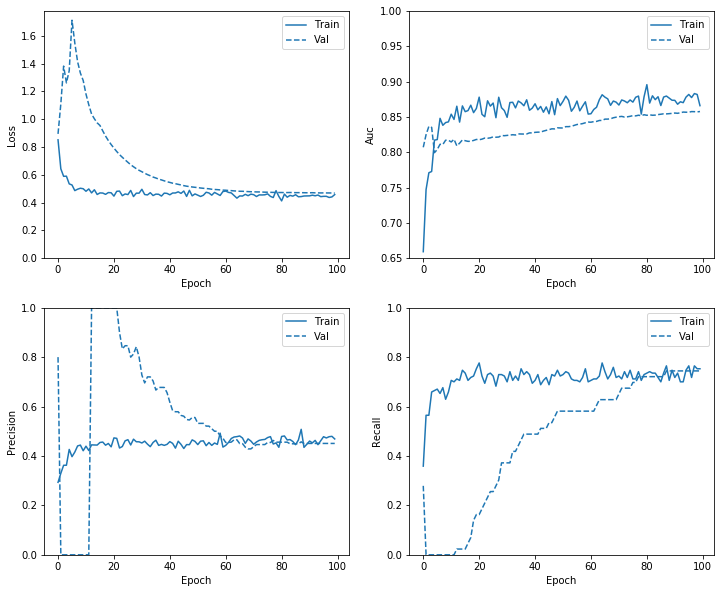

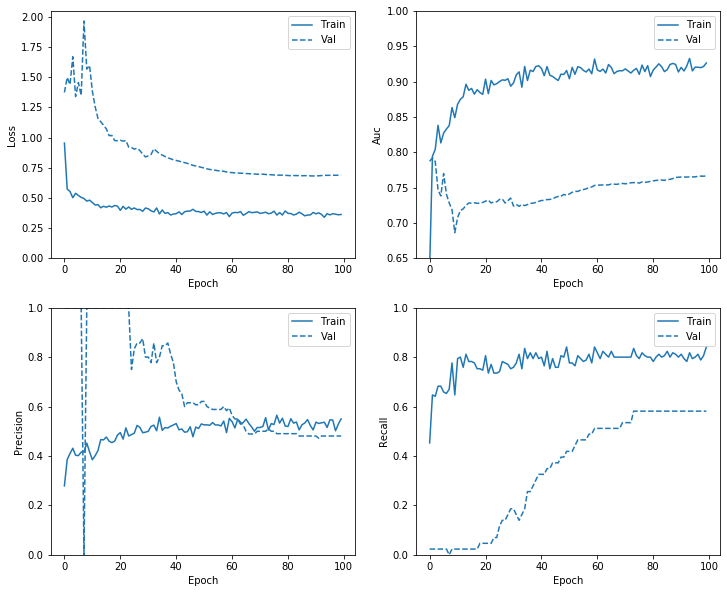

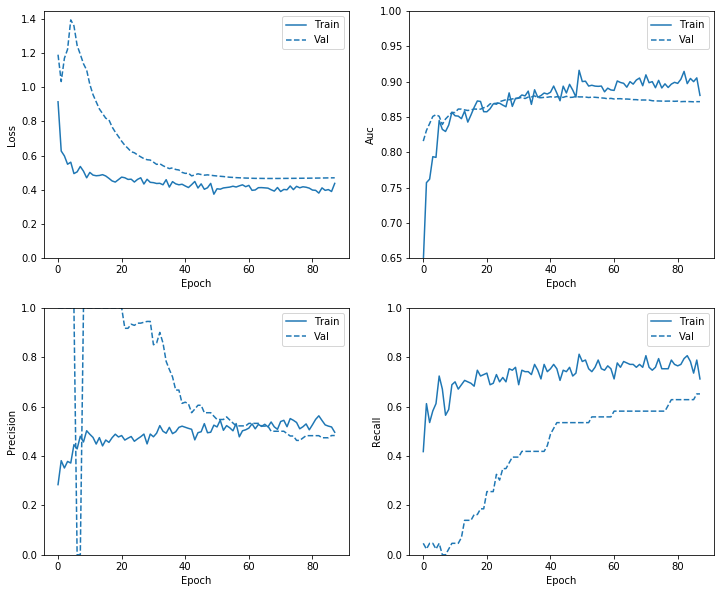

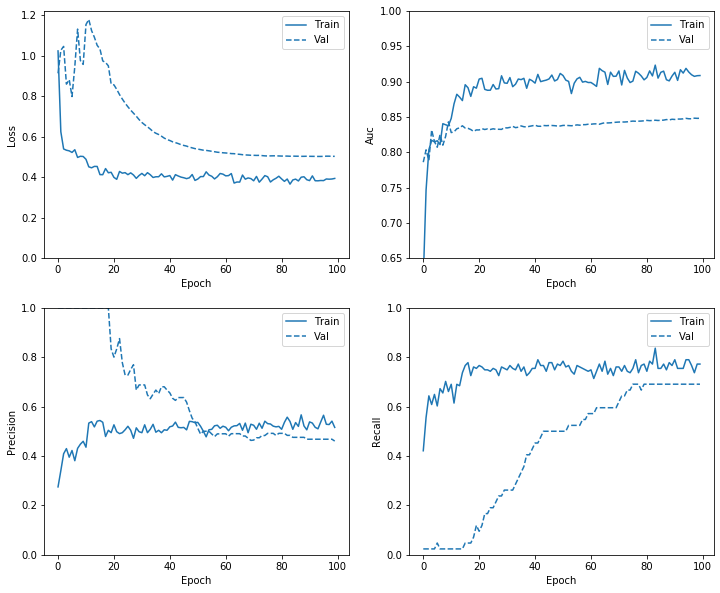

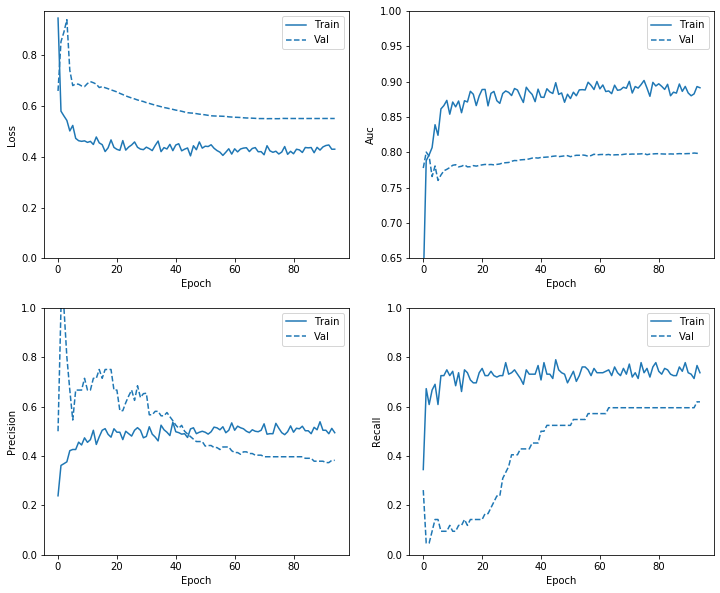

In [93]:
for i, h in enumerate(model_keras_w_history):
    print('Metrics for fold nr:', i+1)
    plot_nn_metrics(h)

### 6.2. Oversampling Series

#### 6.2.1. Optimization - Bayesian Optimization on weighted model

In [94]:
def fit_with_smote(
    learn_rate, 
    l1_neurons, 
    l2_neurons, 
    l2_dropout,
    BATCH_SIZE,
    X = X_SMOTE_mm,
    y = y_SMOTE
):
    X = np.array(train_features)
    y = train_labels
    # Split of data for evaluation (random state defined)
    X, X_val, y, y_val = train_test_split(X, y, stratify=y, random_state=0, test_size=0.1)
    # Instatiate model
    #Loss with correct initialization and saving of bias onto model
    neg_nn, pos_nn = np.bincount(y)
    initial_bias = np.log([pos_nn/neg_nn])
    
    # Discretize parameters
    l1_neurons = max(int(l1_neurons)*2, 32)
    l2_neurons = max(int(l2_neurons)*2, 2)
    BATCH_SIZE = max(int(BATCH_SIZE)*64, 32)
    
    model_keras_opt_smote = make_model(
        metrics = METRICS,
        output_bias = initial_bias,
        learn_rate = 0.001,
        l1_neurons = n_init_neurons,
        l2_neurons = 24,
        input_shape = X.shape[-1:],
        l2_dropout = 0.25
    )
    
    results = model_keras_opt_smote.evaluate(minmax.fit_transform(X_val), y_val, batch_size=BATCH_SIZE, verbose=0)
    initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
    model_keras_opt_smote.save_weights(initial_weights)
    
    # Trainning of the model on the training features
    model_keras_opt_smote.fit(
        minmax.fit_transform(X),
        y,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks = callback,
        validation_data=(minmax.fit_transform(X_val), y_val),
        verbose=0
    )
    
    # Evaluation of model with validation data
    scores = model_keras_opt_smote.evaluate(
        x=X_val, 
        y=y_val,
        verbose=0
    )
    
    tn = scores[5]
    tp = scores[6]
    fn = scores[7]
    fp = scores[8]
    numerator = (tp * tn + fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) + 1e-7
    mc_coef = numerator / denominator
    # The target score to maximize, in this case we think the best is mcc
    return scores[4]

In [95]:
fit_with_partial_smote = partial(fit_with_smote)

optimizer_smote = BayesianOptimization(
    f=fit_with_partial_smote,
    pbounds=p_bounds,
    verbose=2,
    random_state=0
)

optimizer_smote.maximize(
    init_points=10,
    n_iter=n_opt
)

#for i, res in enumerate(optimizer.res):
#    print('Iteration {}: \n\t{}'.format(i, res), end='\r')

print('learn_rate:', optimizer_smote.max['params']['learn_rate'])
print('l1_neurons:', max(int(optimizer_smote.max['params']['l1_neurons'])*2, 32))
print('l2_neurons:', max(int(optimizer_smote.max['params']['l2_neurons'])*2, 2))
print('l2_dropout:', optimizer_smote.max['params']['l2_dropout'])
print('BATCH_SIZE:', max(int(optimizer_smote.max['params']['BATCH_SIZE'])*64, 16))

|   iter    |  target   | BATCH_... | l1_neu... | l2_dro... | l2_neu... | learn_... |
-------------------------------------------------------------------------------------
|  1        |  0.8421   |  2.75     |  34.59    |  0.4822   |  8.083    |  0.04242  |
|  2        |  0.3459   |  3.148    |  27.38    |  0.7134   |  13.53    |  0.03841  |
|  3        |  0.3308   |  3.746    |  29.75    |  0.4544   |  13.03    |  0.007197 |
|  4        |  0.2406   |  0.8572   |  16.53    |  0.6661   |  11.12    |  0.08701  |
|  5        |  0.8421   |  4.512    |  36.78    |  0.3692   |  11.15    |  0.01192  |
|  6        |  0.1654   |  3.124    |  19.73    |  0.7557   |  7.784    |  0.04152  |
|  7        |  0.8421   |  1.585    |  36.13    |  0.3649   |  8.39     |  0.001977 |
|  8        |  0.1579   |  3.032    |  31.91    |  0.4935   |  13.27    |  0.06821  |
|  9        |  0.2632   |  1.974    |  27.36    |  0.5581   |  1.783    |  0.06671  |
|  10       |  0.8421   |  3.25     |  21.47    |  0.1

In [96]:
import time
timestamp = time.gmtime()

with open('../logs/nn_opt_log.txt', 'a') as file:
    file.write(str(timestamp) + '\n')
    file.write('smote: ' + str(optimizer_smote.max) + '\n')
    file.write('---------------------------------------------------------------- \n')
file.close()

In [97]:
learn_rate = optimizer_smote.max['params']['learn_rate']
l1_neurons = max(int(optimizer_smote.max['params']['l1_neurons'])*2, 32)
l2_neurons = max(int(optimizer_smote.max['params']['l2_neurons'])*2, 2)
l2_dropout = optimizer_smote.max['params']['l2_dropout']
BATCH_SIZE = max(int(optimizer_smote.max['params']['BATCH_SIZE'])*64, 16)

tf.keras.backend.clear_session()

#### 6.2.2. Evaluation - Stratified K-Fold CV

In [99]:
model_keras_smote_history = []
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_v, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...", end='\r')
    # Generate batches from indices
    xtrain, xval = train_features_v[train_indices], train_features_v[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # Oversampling training sets
    xtrain_SMOTE, ytrain_SMOTE = smote.fit_sample(xtrain, ytrain)
    xtrain_SMOTE = minmax.fit_transform(xtrain_SMOTE)
    xval = minmax.fit_transform(xval)
    
    # Clear model
    model_keras_smote = None
    
    #Loss with correct initialization and saving of bias onto model
    neg_nn, pos_nn = np.bincount(ytrain_SMOTE)
    initial_bias = np.log([pos_nn/neg_nn])
    model_keras_smote = make_model(output_bias = initial_bias)
    results = model_keras_smote.evaluate(xtrain, ytrain, batch_size=BATCH_SIZE, verbose=0)
    initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
    model_keras_smote.save_weights(initial_weights)

    baseline_history_smote = model_keras_smote.fit(
        xtrain_SMOTE,
        ytrain_SMOTE,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks = callback,
        validation_data=(xval, yval),
        verbose=0)

    model_keras_smote_history.append(baseline_history_smote)
    m_summary = save_metrics(
        m_summary, 'NN_weighted', ytrain_SMOTE, model_keras_smote.predict_classes(xtrain_SMOTE), model_keras_smote.predict_proba(xtrain_SMOTE),
        batch_size=BATCH_SIZE, split_data='train', series='SMOTE')
    m_summary = save_metrics(
        m_summary, 'NN_weighted', yval, model_keras_smote.predict_classes(xval), model_keras_smote.predict_proba(xval),
        batch_size=BATCH_SIZE, split_data='val', series='SMOTE')
    m_summary = save_metrics(
        m_summary, 'NN_weighted', test_labels, model_keras_smote.predict_classes(test_features), model_keras_smote.predict_proba(test_features),
        batch_size=BATCH_SIZE, split_data='test', series='SMOTE')
print(' ...Done')

 ...Done on fold 5/5...


Metrics for fold nr: 1
Metrics for fold nr: 2
Metrics for fold nr: 3
Metrics for fold nr: 4
Metrics for fold nr: 5


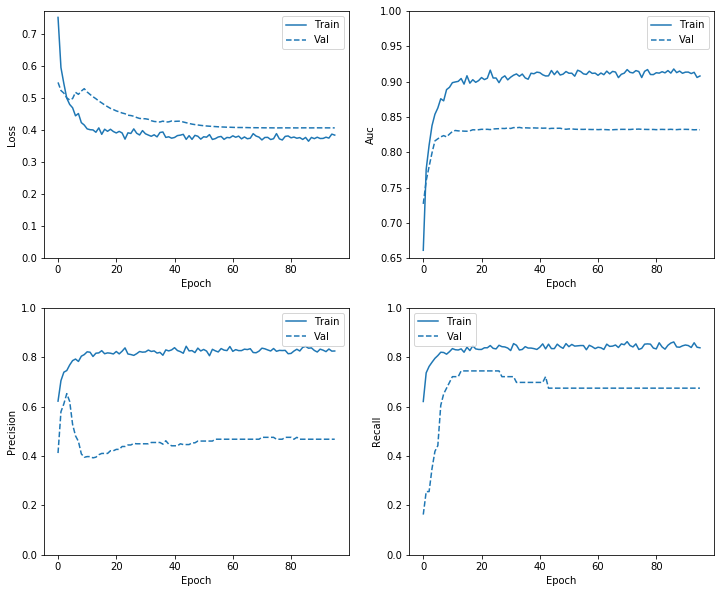

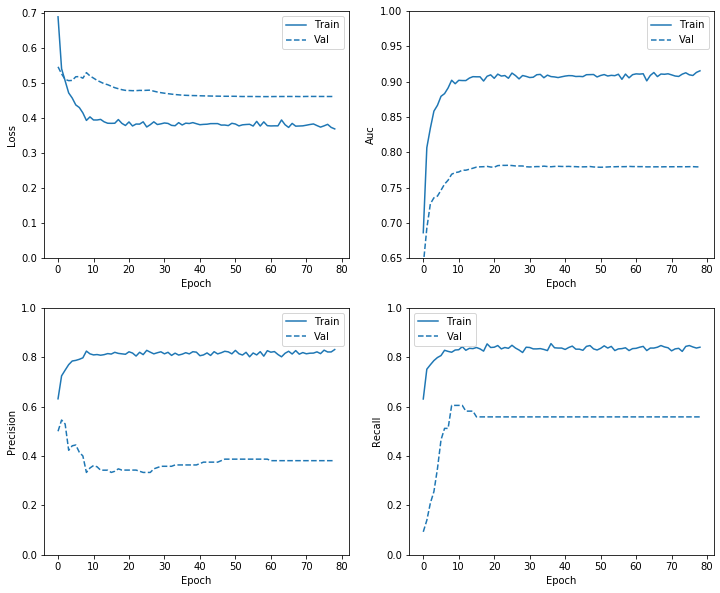

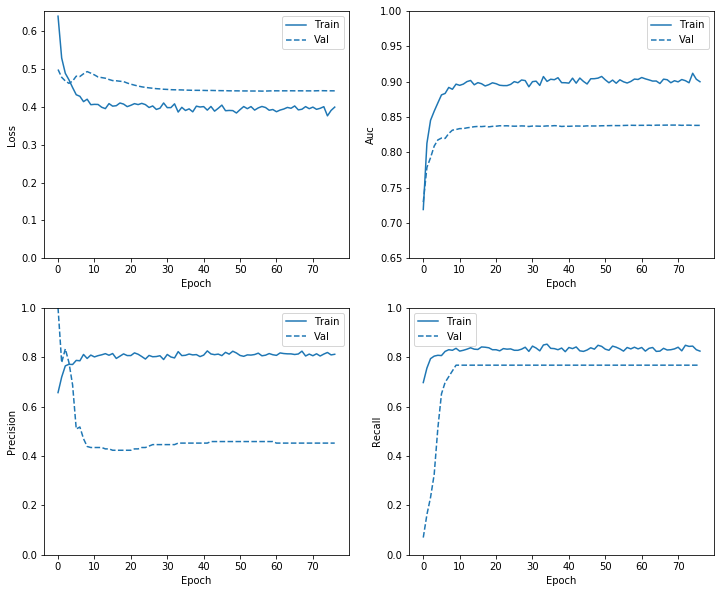

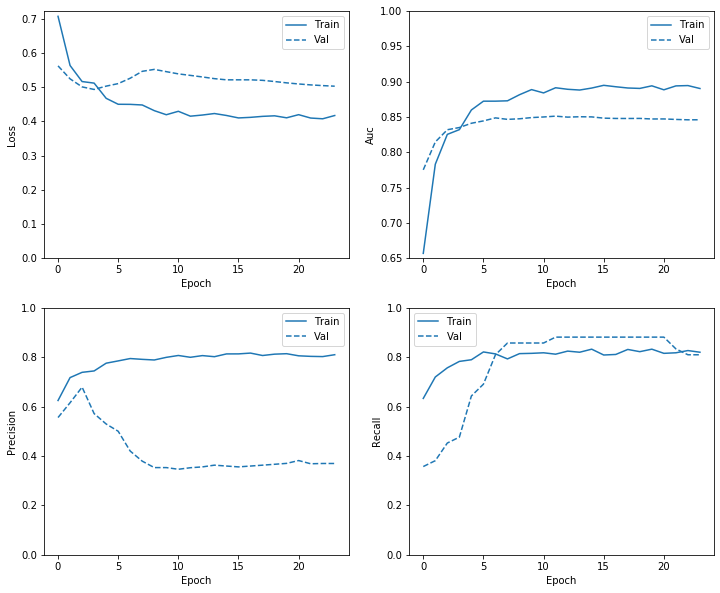

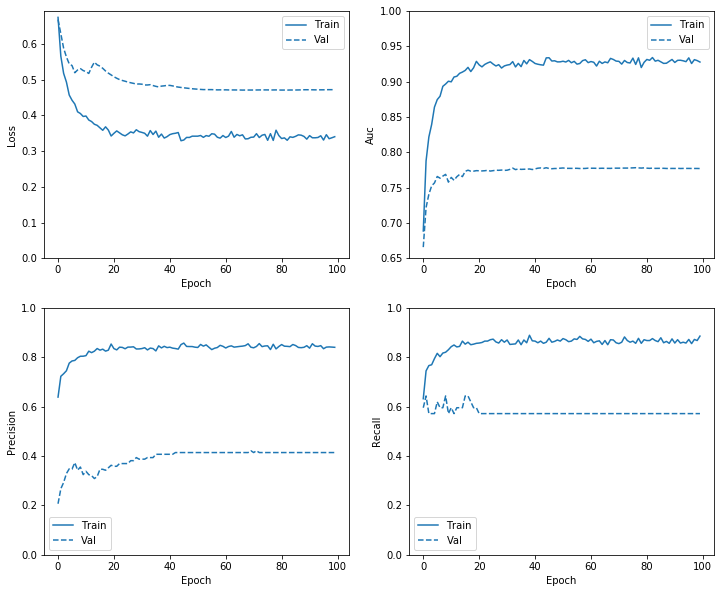

In [100]:
for i, h in enumerate(model_keras_smote_history):
    print('Metrics for fold nr:', i+1)
    plot_nn_metrics(h)

# ...

# III. Selecting Best Models

The selection of the best model(s) is based on the following ordered metrics:
1. The Matthews correlation coeficient;
    * Measures of the quality of binary (two-class) classifications
    * Takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes.
    * In essence a correlation coefficient between the observed and predicted binary classifications
2. Recall;
    * Probability of finding a True positive taking into account False negatives (Tipe II error)
    * In our case, we better have a model that identifies all attrition (True positives) instead of being only accurate in True negatives
3. Precision vs Recall AUC.
    * The Area under the curve of Precision vs Recall curve do not consider true negatives
    * Used when precision is of no concern for the classifier, which is the case.

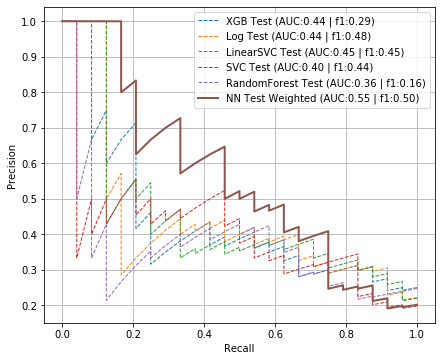

In [101]:
plt.figure(figsize=(7, 7))
plot_pr_curve("XGB Test", test_labels, model_XGB.predict_proba(test_features)[:, 1], model_XGB.predict(test_features), lcolor=colors[0], lstyle='--', lwidth=1)

plot_pr_curve("Log Test", test_labels, model_logistic.predict_proba(test_features)[:, 1], model_logistic.predict(test_features), lcolor=colors[1], lstyle='--', lwidth=1)

plot_pr_curve("LinearSVC Test", test_labels, model_LinearSVC.decision_function(test_features), model_LinearSVC.predict(test_features), lcolor=colors[2], lstyle='--', lwidth=1)

plot_pr_curve("SVC Test", test_labels, model_SVC.predict_proba(test_features)[:, 1], model_SVC.predict(test_features), lcolor=colors[3], lstyle='--', lwidth=1)

plot_pr_curve("RandomForest Test", test_labels, model_RandomForest.predict_proba(test_features)[:, 1], model_RandomForest.predict(test_features), lcolor=colors[4], lstyle='--', lwidth=1)

plot_pr_curve("NN Test Weighted", test_labels, model_keras_w.predict_proba(test_features), model_keras_w.predict_classes(test_features, batch_size=BATCH_SIZE), lcolor=colors[5], lstyle='-')
plt.legend(loc='upper right')
plt.show()

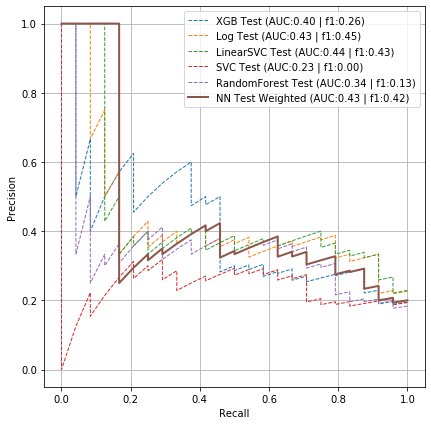

In [102]:
plt.figure(figsize=(7, 7))
plot_pr_curve("XGB Test", test_labels, model_XGB_smote.predict_proba(test_features)[:, 1], model_XGB_smote.predict(test_features), lcolor=colors[0], lstyle='--', lwidth=1)

plot_pr_curve("Log Test", test_labels, model_logistic_smote.predict_proba(test_features)[:, 1], model_logistic_smote.predict(test_features), lcolor=colors[1], lstyle='--', lwidth=1)

plot_pr_curve("LinearSVC Test", test_labels, model_LinearSVC_smote.decision_function(test_features), model_LinearSVC_smote.predict(test_features), lcolor=colors[2], lstyle='--', lwidth=1)

plot_pr_curve("SVC Test", test_labels, model_SVC_smote.predict_proba(test_features)[:, 1], model_SVC_smote.predict(test_features), lcolor=colors[3], lstyle='--', lwidth=1)

plot_pr_curve("RandomForest Test", test_labels, model_RandomForest_smote.predict_proba(test_features)[:, 1], model_RandomForest_smote.predict(test_features), lcolor=colors[4], lstyle='--', lwidth=1)

plot_pr_curve("NN Test Weighted", test_labels, model_keras_smote.predict_proba(test_features), model_keras_smote.predict_classes(test_features, batch_size=BATCH_SIZE), lcolor=colors[5], lstyle='-')
plt.legend(loc='upper right')
plt.show()

In [105]:
m_summary[['tp', 'fp', 'tn', 'fn']] = m_summary[['tp', 'fp', 'tn', 'fn']].astype(int)

In [106]:
m_summary.groupby(['model', 'data', 'series']).mean().sort_values(by=['mc_coef', 'recall', 'pr_auc'], ascending=False).applymap(lambda x: np.round(x,2))

tp      fp      tn      fn  bal_acc  \
model              data  series                                                
model_SVC          train SMOTE       888.00    0.00  888.00    0.00     1.00   
model_XGB          train imbalanced  170.40    0.00  888.00    0.00     1.00   
                         SMOTE       866.00    0.80  887.20   22.00     0.99   
model_RandomForest train SMOTE       858.40    0.60  887.40   29.60     0.98   
                         imbalanced  142.00   26.60  861.40   28.40     0.90   
NN_weighted        train SMOTE       697.20  121.60  766.40  190.80     0.82   
model_LinearSVC    train SMOTE       743.60  187.40  700.60  144.40     0.81   
model_logistic     train SMOTE       740.20  213.40  674.60  147.80     0.80   
NN_weighted        val   imbalanced   33.33   30.00  192.00    8.67     0.83   
model_LinearSVC    train imbalanced  138.40  200.20  687.80   32.00     0.79   
model_logistic     train imbalanced  135.33  191.00  697.00   35.00     0.79   
                   val   SMOTE        33.40   51.60  170.40    9.20     0.78   
model_RandomForest val   imbalanced   18.80   14.00  208.00   23.80     0.69   
NN_weighted        val   SMOTE        26.00   31.80  190.20   16.60     0.73   
model_SVC          val   imbalanced   31.40   50.40  171.60   11.20     0.75   
model_logistic     val   imbalanced   31.33   50.33  171.67   11.33     0.75   
model_RandomForest val   SMOTE        12.00    4.20  217.80   30.60     0.63   
model_LinearSVC    val   SMOTE        30.00   46.40  175.60   12.60     0.75   
model_XGB          val   imbalanced   13.00    6.20  215.80   29.60     0.64   
model_LinearSVC    val   imbalanced   31.20   52.80  169.20   11.40     0.75   
model_SVC          train imbalanced  122.40  211.60  676.40   48.00     0.74   
model_logistic     test  SMOTE        15.00   23.00  100.00    9.00     0.72   
model_LinearSVC    test  SMOTE        14.00   22.00  101.00   10.00     0.70   
model_logistic     test  imbalanced   14.20   22.80  100.20    9.80     0.70   
model_LinearSVC    test  imbalanced   14.20   24.00   99.00    9.80     0.70   
NN_weighted        test  SMOTE        11.00   14.80  108.20   13.00     0.67   
model_XGB          test  imbalanced    4.80    2.00  121.00   19.20     0.59   
model_SVC          test  imbalanced   14.80   27.20   95.80    9.20     0.70   
model_XGB          test  SMOTE         5.00    2.80  120.20   19.00     0.59   
NN_weighted        test  imbalanced   10.33   15.50  107.50   13.67     0.65   
model_RandomForest test  SMOTE         2.60    2.00  121.00   21.40     0.55   
model_SVC          val   SMOTE         2.00    1.00  221.00   40.60     0.52   
model_RandomForest test  imbalanced    4.20    9.40  113.60   19.80     0.55   
model_XGB          val   SMOTE         0.80    0.00  222.00   41.80     0.51   
NN_weighted        train imbalanced  170.83  887.83    0.17    0.17     0.50   
model_SVC          test  SMOTE         0.00    0.60  122.40   24.00     0.50   

                                     prec  recall  pr_auc    f1  mc_coef  \
model              data  series                                            
model_SVC          train SMOTE       1.00    1.00    1.00  1.00     1.00   
model_XGB          train imbalanced  1.00    1.00    1.00  1.00     1.00   
                         SMOTE       1.00    0.98    1.00  0.99     0.97   
model_RandomForest train SMOTE       1.00    0.97    1.00  0.98     0.97   
                         imbalanced  0.84    0.83    0.92  0.84     0.81   
NN_weighted        train SMOTE       0.86    0.79    0.92  0.81     0.66   
model_LinearSVC    train SMOTE       0.80    0.84    0.89  0.82     0.63   
model_logistic     train SMOTE       0.78    0.83    0.87  0.80     0.59   
NN_weighted        val   imbalanced  0.53    0.79    0.75  0.63     0.57   
model_LinearSVC    train imbalanced  0.41    0.81    0.65  0.54     0.46   
model_logistic     train imbalanced  0.42    0.79    0.64  0.55     0.46   
            

In [107]:
m_summary.to_csv('../logs/metrics_summary.csv')

In [108]:
m_summary[m_summary['data'] == 'val'].groupby(['model', 'data', 'series']).mean().sort_values(by=['mc_coef', 'recall', 'pr_auc'], ascending=False).applymap(lambda x: np.round(x,2))

,,,tp,fp,tn,fn,bal_acc,prec,recall,pr_auc,f1,mc_coef,batch_s
model,data,series,,,,,,,,,,,
NN_weighted,val,imbalanced,33.33,30.00,192.00,8.67,0.83,0.53,0.79,0.75,0.63,0.57,192.0
model_logistic,val,SMOTE,33.40,51.60,170.40,9.20,0.78,0.39,0.78,0.61,0.52,0.43,NaN
model_RandomForest,val,imbalanced,18.80,14.00,208.00,23.80,0.69,0.57,0.44,0.54,0.50,0.42,NaN
NN_weighted,val,SMOTE,26.00,31.80,190.20,16.60,0.73,0.46,0.61,0.57,0.52,0.42,128.0
model_SVC,val,imbalanced,31.40,50.40,171.60,11.20,0.75,0.38,0.74,0.56,0.50,0.41,NaN
model_logistic,val,imbalanced,31.33,50.33,171.67,11.33,0.75,0.38,0.73,0.56,0.50,0.40,NaN
model_RandomForest,val,SMOTE,12.00,4.20,217.80,30.60,0.63,0.75,0.28,0.56,0.41,0.40,NaN
model_LinearSVC,val,SMOTE,30.00,46.40,175.60,12.60,0.75,0.39,0.70,0.56,0.50,0.40,NaN
model_XGB,val,imbalanced,13.00,6.20,215.80,29.60,0.64,0.69,0.30,0.55,0.42,0.40,NaN


In [109]:
m_summary_melted = pd.melt(
    m_summary, 
    id_vars=['model', 'data', 'series'], 
    value_vars=[
        'tp', 'fp', 'tn', 'fn', 
        'bal_acc', 'prec', 'recall', 'pr_auc', 'f1', 'mc_coef'
    ], 
    var_name='metrics', 
    value_name='values')

m_summary_melted.to_csv('../logs/metrics_summary_melted.csv')

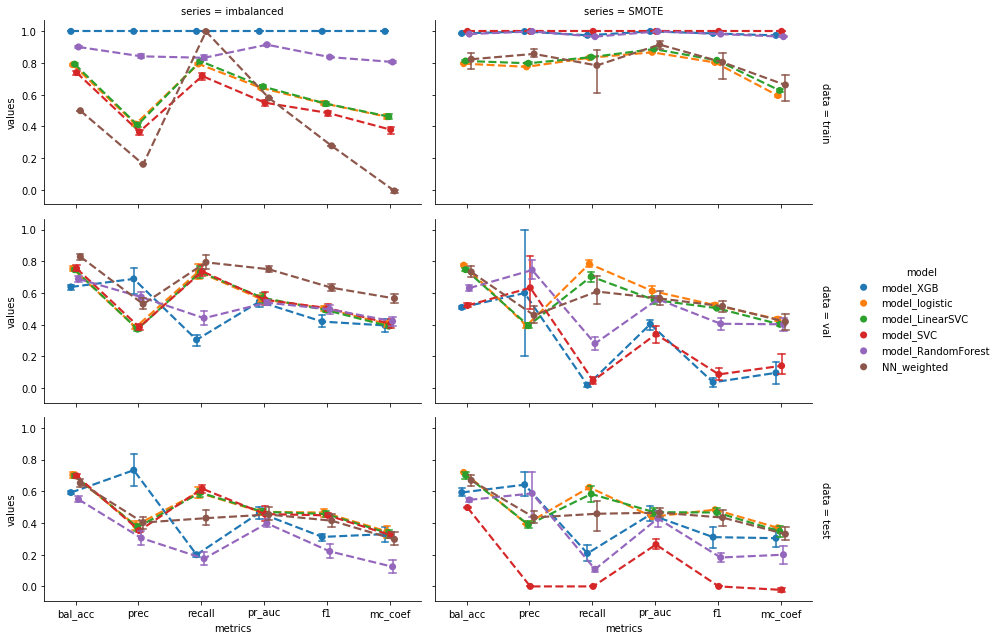

In [110]:
sb.catplot(
    y='values',
    x='metrics',
    hue='model',
    data=m_summary_melted[m_summary_melted.metrics.isin(['bal_acc', 'prec', 'recall', 'pr_auc', 'f1', 'mc_coef'])], 
    col='series', 
    row='data',
    estimator= np.mean,
    ci=95, 
    n_boot=1000, 
    kind='point', 
    height=3,
    aspect=2, 
    palette='tab10', 
    legend=True, 
    legend_out=True, 
    sharex=True, 
    sharey=True, 
    margin_titles=True, 
    **{
        'linestyles':'--',
        'scale':0.8,
        'dodge':True,
        'capsize':0.1,
        'errwidth':1.5
    }
)
plt.show()

plot pr curve with mean

## 1. Feature importance

### D.1 Logistic Model

In [111]:
from scipy import stats
params = np.append(model_logistic.intercept_,model_logistic.coef_)
predictions = model_logistic.predict(test_features)

newX = pd.DataFrame({"Constant":np.ones(len(test_features))}).join(pd.DataFrame(test_features))
MSE = (sum((test_labels-predictions)**2))/(len(newX)-len(newX.columns))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["features"],myDF3["coef"],myDF3["se"],myDF3["t_values"],myDF3["p_value"] = [test_df.columns.to_list(), params,sd_b,ts_b,p_values]
myDF3[myDF3['p_value'] < 0.05].sort_values(by=['coef'], ascending=False)

data_pre_proc.py:9: RuntimeWarning: invalid value encountered in sqrt
  df = pd.read_csv(dataset_path)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


,features,coef,se,t_values,p_value
41,OverTime_Yes,1.6586,0.129,12.898,0.000
38,JobRole_SalesRepresentative,1.6314,0.590,2.764,0.006
32,JobRole_LaboratoryTechnician,1.1797,0.257,4.592,0.000
18,YearsWithCurrManager,1.1724,0.347,3.377,0.001
3,Education,0.9788,0.173,5.656,0.000
40,MaritalStatus_Single,0.8816,0.181,4.868,0.000
39,MaritalStatus_Married,0.5590,0.135,4.144,0.000
30,Gender_Male,0.2276,0.109,2.081,0.039
13,StockOptionLevel,-0.3868,0.141,-2.750,0.007
22,BusinessTravel_Rarely,-0.4379,0.136,-3.228,0.002


Least important features:

In [112]:
myDF3[myDF3['p_value'] > 0.05].sort_values(by=['coef'], ascending=False)

,features,coef,se,t_values,p_value
29,EducationField_TechnicalDegree,1.1301,0.634,1.783,0.077
28,EducationField_Other,0.4097,0.635,0.645,0.520
26,EducationField_Marketing,0.3356,0.627,0.535,0.593
34,JobRole_ManufacturingDirector,0.3310,0.230,1.438,0.152
37,JobRole_SalesExecutive,0.3115,0.548,0.568,0.571
4,EnvironmentSatisfaction,0.2645,0.257,1.031,0.304
36,JobRole_ResearchScientist,0.2627,0.248,1.057,0.292
27,EducationField_Medical,0.1117,0.612,0.183,0.855
6,JobInvolvement,0.1077,0.176,0.612,0.541
9,MonthlyRate,0.1014,0.521,0.194,0.846


### D.2 XGBoost

In [113]:
import xgboost

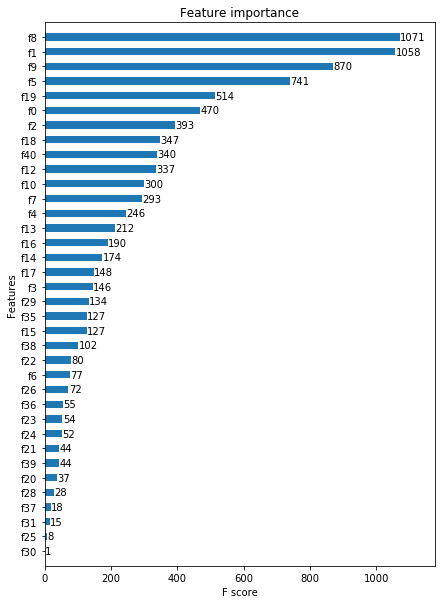

In [114]:
fig, ax = plt.subplots(1,1,figsize=(7,10))
#model_XGB.get_booster().feature_names = train_df.columns
xgboost.plot_importance(model_XGB, height=0.5, ax=ax, grid=False)
plt.show()

### D.3 LinearSVC

In [115]:
lsvc = pd.DataFrame({'features':train_features.columns, 'coefs':model_LinearSVC.coef_.ravel()}).sort_values(by='coefs')
lsvc_pos_class = lsvc[lsvc.coefs > 0].sort_values(by='coefs', ascending=False)
lsvc_neg_class = lsvc[lsvc.coefs < 0].sort_values(by='coefs', ascending=True)

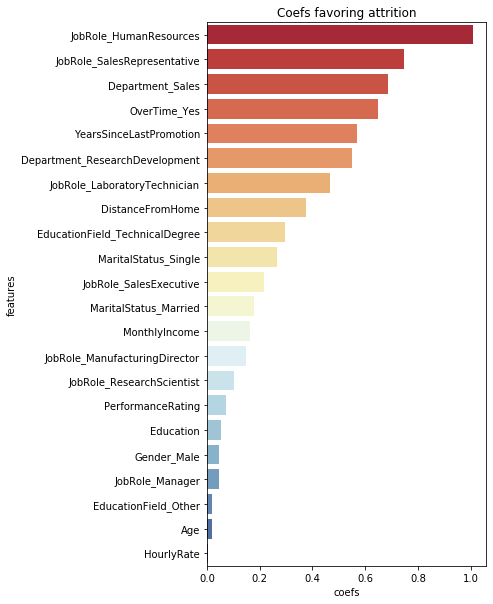

In [116]:
plt.figure(figsize=(5,10))
sb.barplot(lsvc_pos_class.coefs, lsvc_pos_class.features, palette="RdYlBu")
plt.title('Coefs favoring attrition')
plt.show()

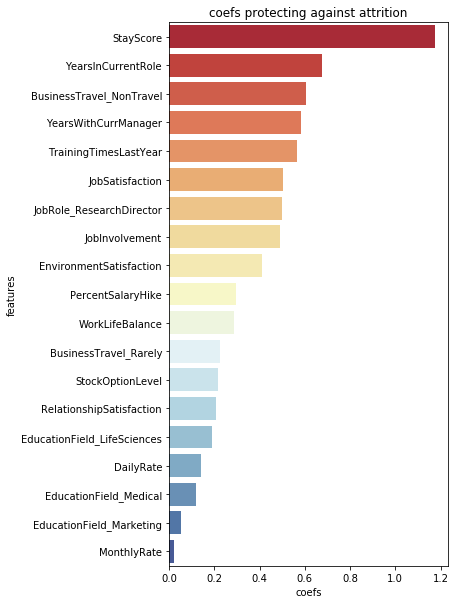

In [117]:
plt.figure(figsize=(5,10))
sb.barplot(lsvc_neg_class.coefs*-1, lsvc_neg_class.features, palette="RdYlBu")
plt.title('coefs protecting against attrition')
plt.show()

In [118]:
from mlxtend.evaluate import feature_importance_permutation

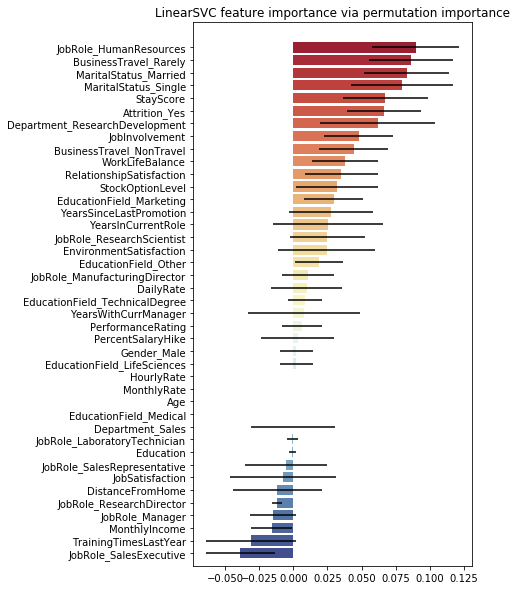

In [119]:
imp_vals, imp_all = feature_importance_permutation(
    predict_method=model_LinearSVC.predict, 
    X=test_features,
    y=test_labels,
    metric=metrics.f1_score,
    num_rounds=100,
    seed=1)

X=test_df
y=test_labels

#imp_vals = minmax.fit_transform(imp_vals.reshape(-1,1)).ravel()

std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::1]

plt.figure(figsize=(5,10))
plt.title("LinearSVC feature importance via permutation importance")
sb.barplot(y=test_df.columns[indices], x=imp_vals[indices], xerr=std[indices], palette="RdYlBu_r")
#plt.barh(test_df.columns[indices], imp_vals[indices], xerr=std[indices])
#plt.yticks(range(X.shape[1]), test_df.columns[indices])
plt.ylim([-1, X.shape[1]])
plt.show()

### D.4 Weighted NN

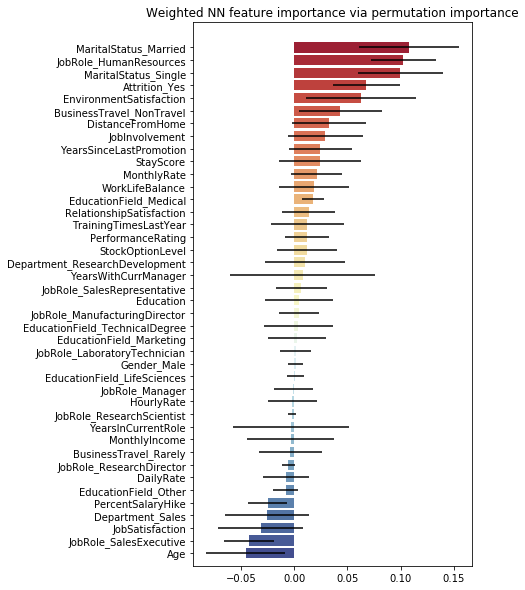

In [120]:
imp_vals, imp_all = feature_importance_permutation(
    predict_method=model_keras_w.predict_classes, 
    X=test_features,
    y=test_labels,
    metric=metrics.f1_score,
    num_rounds=50,
    seed=1)

X=test_df
y=test_labels

#imp_vals = minmax.fit_transform(imp_vals.reshape(-1,1)).ravel()

std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::1]

plt.figure(figsize=(5,10))
plt.title("Weighted NN feature importance via permutation importance")
sb.barplot(y=test_df.columns[indices], x=imp_vals[indices], xerr=std[indices], palette="RdYlBu_r")
plt.ylim([-1, X.shape[1]])
plt.show()

## 2. Recursive Feature Selection with Stratified Kfold CV

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Optimal number of features : 15


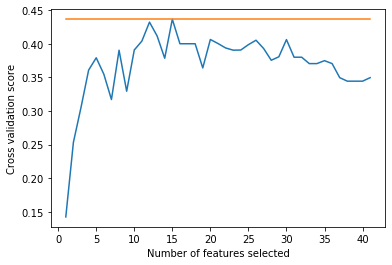

In [121]:
from sklearn.feature_selection import RFECV

# Logistic Model
rfecv = RFECV(estimator=model_logistic, step=1, cv=StratifiedKFold(5, shuffle=True, random_state=0),
              scoring='f1')
#rfecv.fit(finaldf.drop(['Attrition_Yes'], axis=1), finaldf.Attrition_Yes)
rfecv.fit(test_features, test_labels)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), [max(rfecv.grid_scores_) for i in range(1, len(rfecv.grid_scores_) + 1)])
plt.show()

In [122]:
l = []
for (i, feat), rank in zip(enumerate(test_df.columns), rfecv.ranking_):
    if rank == 1:
        l.append((feat, i))
print('Best ranking features:\n',l)

Best ranking features:
 [('EnvironmentSatisfaction', 4), ('HourlyRate', 5), ('JobInvolvement', 6), ('MonthlyRate', 9), ('RelationshipSatisfaction', 12), ('TrainingTimesLastYear', 14), ('YearsInCurrentRole', 16), ('Attrition_Yes', 20), ('EducationField_TechnicalDegree', 29), ('JobRole_HumanResources', 31), ('JobRole_ManufacturingDirector', 34), ('JobRole_ResearchDirector', 35), ('JobRole_ResearchScientist', 36), ('MaritalStatus_Married', 39), ('MaritalStatus_Single', 40)]


## 3. Cluster Profile & Analysis

In [124]:
from sklearn.cluster import KMeans, DBSCAN

In [125]:
km_model = KMeans(
    n_clusters=n_kn,
    n_jobs=-1,
    n_init=30,
    random_state=123)

km_model.fit(traindf_norm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=30, n_jobs=-1, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

In [126]:
clusters = km_model.labels_

In [127]:
traindf_norm['cluster'] = clusters

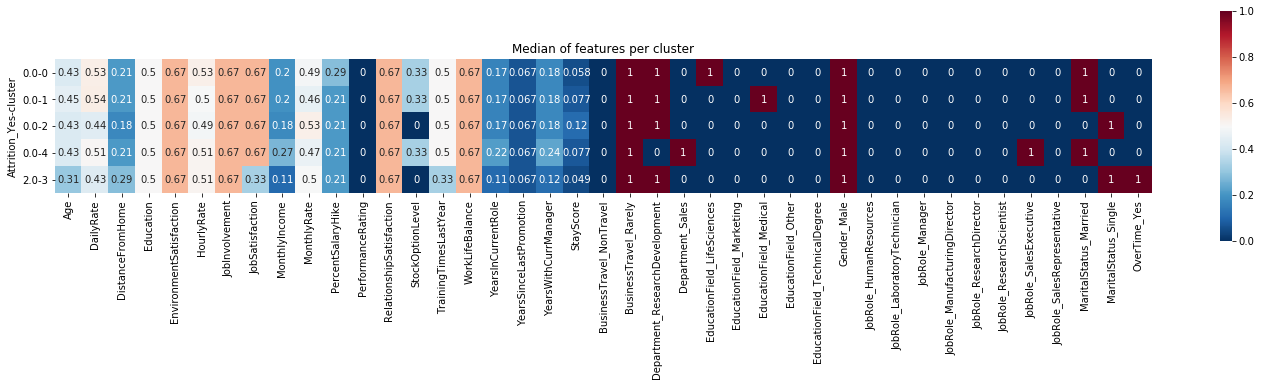

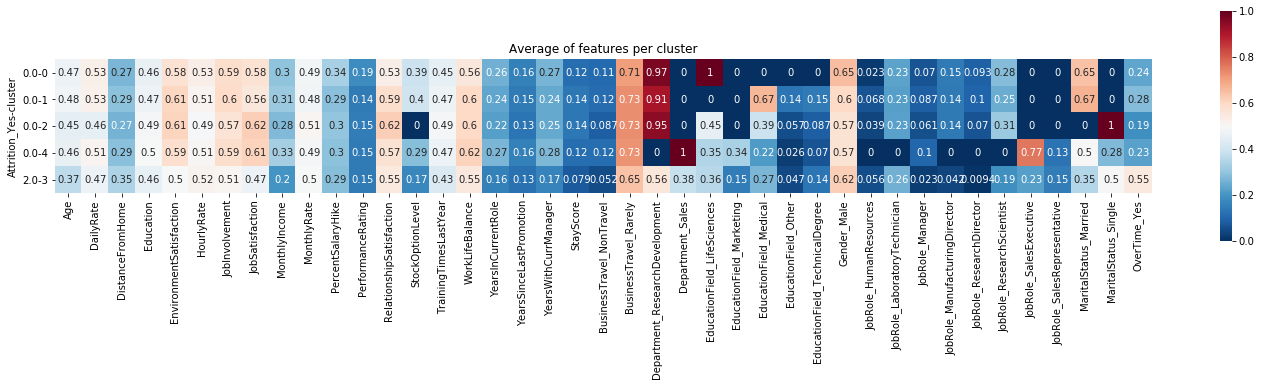

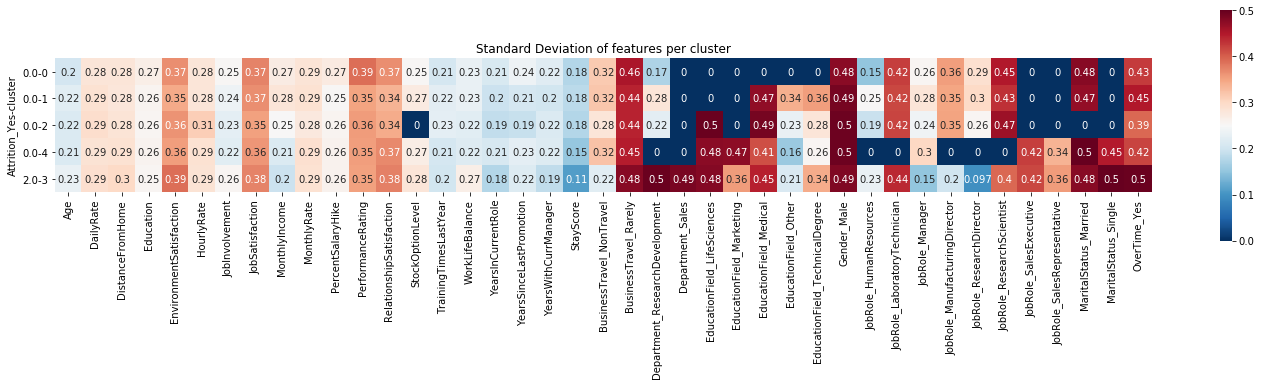

In [130]:
plt.figure(figsize=(20,5))
sb.heatmap(
    traindf_norm.groupby(['Attrition_Yes', 'cluster']).median(),
    cmap='RdBu_r',
    square=True,
    annot=True
)
plt.title('Median of features per cluster')
plt.tight_layout()
plt.show()
plt.figure(figsize=(20,5))
sb.heatmap(
    traindf_norm.groupby(['Attrition_Yes', 'cluster']).mean(),
    cmap='RdBu_r',
    square=True,
    annot=True
)
plt.title('Average of features per cluster')
plt.tight_layout()
plt.show()
plt.figure(figsize=(20,5))
sb.heatmap(
    traindf_norm.groupby(['Attrition_Yes', 'cluster']).std(),
    cmap='RdBu_r',
    square=True,
    annot=True
)
plt.title('Standard Deviation of features per cluster')
plt.tight_layout()
plt.show()

# IV. Conclusions